
## First steps:

- Sample some points from a gaussian mixture
    - Fixed sample sizes (one big, one small), 5 different random seeds
- Create both kde and normal histograms for some binning and bandwidth
- Value of truth dist bin is area under curve between bin endpoints (just like kde hist!)
- Make these plots for a range of bandwidths

### Expected behavior:

- stdev of count estimate across random seeds decreases with more samples
- for large bandwidth, you will see a bias error, as you're smoothing out the shape of the distribution



In [127]:
import jax
import jax.numpy as jnp
from jax.random import normal, PRNGKey
rng = PRNGKey(7)

from matplotlib.colors import to_rgb
import matplotlib.pyplot as plt
plt.rc('figure',figsize=[7.3,5],dpi=120,facecolor='w')

from functools import partial

Let's generate `num_samples` points from a set of normal distributions with slowly increasing means:

In [128]:
lo, hi = -2, 2
grid_points = 500
mu_grid = jnp.linspace(lo, hi, grid_points)

In [129]:
num_samples = 100
points = jnp.tile(
    normal(rng, shape = (num_samples,)), 
    reps = (grid_points,1)
    ) + mu_grid.reshape(-1,1)
points.shape

(500, 100)

Each index of `points` is a set of `num_samples` samples drawn for a given $\mu$ value. We want to make histograms for these sets of points, and then focus our attention on just one bin.

In [130]:
bins = jnp.linspace(lo-1,hi+1,6)
make_hists = jax.vmap(partial(jnp.histogram, bins = bins))
hists, _ = make_hists(points)

We can start by inspecting a couple of these histograms to see the behaviour of varying $\mu$ upwards:

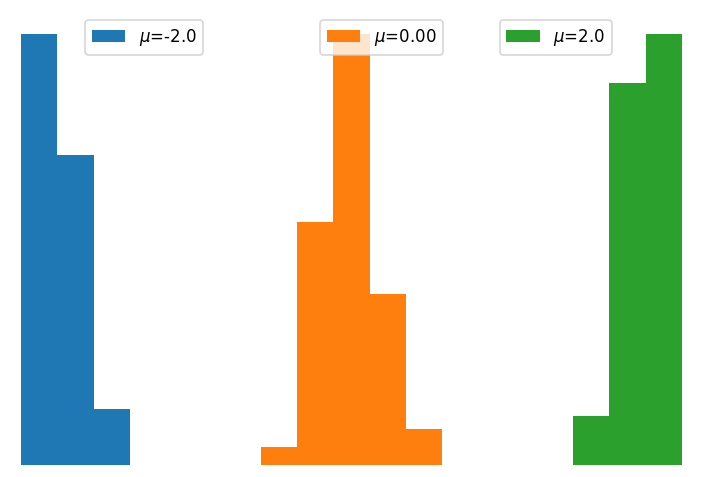

In [131]:
centers = bins[:-1] + jnp.diff(bins) / 2.0
width = (bins[-1] - bins[0])/(len(bins) - 1)

fig, axs = plt.subplots(1,3)

# first mu value
axs[0].bar(
    centers, 
    hists[0], 
    width = width, 
    label=f'$\mu$={mu_grid[0]}'
)
axs[0].legend()
axs[0].axis('off')

# middle mu value
axs[1].bar(
    centers, hists[len(hists)//2], 
    width = width, 
    label=f'$\mu$={mu_grid[len(hists)//2]:.2f}',
    color = 'C1'
)
axs[1].legend()
axs[1].axis('off')

# last mu value
axs[2].bar(
    centers, 
    hists[-1], 
    width = width, 
    label=f'$\mu$={mu_grid[-1]}',
    color = 'C2'
)
axs[2].legend()
axs[2].axis('off');

As one may expect, shifting $\mu$ to the right subsequently skews the resulting histogram. 

Now, let's focus on the behavior of the middle bin by plotting its height across a large range of $\mu$ values:

In [132]:
# cool color scheme
from matplotlib.colors import to_rgb

def fade(c1,c2, num_points):
    start = jnp.array(to_rgb(c1))
    end = jnp.array(to_rgb(c2))
    interp = jax.vmap(partial(jnp.linspace, num=num_points))
    return interp(start,end).T

color_scheme = fade('C1', 'C3', num_points=grid_points)

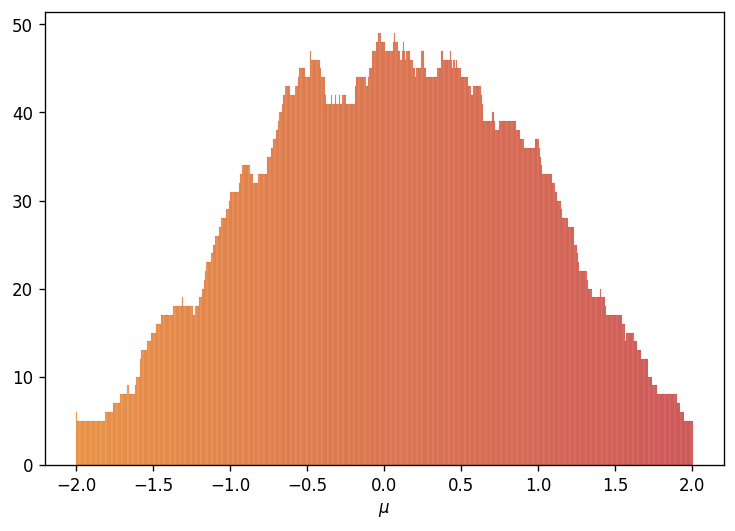

In [133]:
middle = len(bins)//2 - 1
mu_width = mu_grid[1]-mu_grid[0]
plt.bar(mu_grid, hists[:,middle], color=color_scheme, width=mu_width, edgecolor= 'black',linewidth = 0.05,alpha=0.7)
plt.xlabel('$\mu$');

We can see that this bin goes up then down in value as expected, but it does so in a jagged, unfriendly way, meaning that the gradient of the bin height with respect to $\mu$ is also badly behaved. This gradient is crucial to evaluate if you want to do end-to-end optimization, since histograms are an extremely common component in high-energy physics.

A solution to remedy this jaggedness can be found by changing the way we construct the histogram. In particular, we can perform a kernel density estimate for each set of samples, then discretize the result by partitioning the area under the curve with the same binning as we used to make the histogram.

In [134]:
import jax.scipy as jsc


def kde_hist(events, bins, bandwidth=None, density=False):
    
    edge_hi = bins[1:]  # ending bin edges ||<-
    edge_lo = bins[:-1]  # starting bin edges ->||

    # get cumulative counts (area under kde) for each set of bin edges
    cdf_up = jsc.stats.norm.cdf(edge_hi.reshape(-1, 1), loc=events, scale=bandwidth)
    cdf_dn = jsc.stats.norm.cdf(edge_lo.reshape(-1, 1), loc=events, scale=bandwidth)
    # sum kde contributions in each bin
    counts = (cdf_up - cdf_dn).sum(axis=1)

    if density:  # normalize by bin width and counts for total area = 1
        db = jnp.array(jnp.diff(bins), float)  # bin spacing
        return counts / db / counts.sum(axis=0)

    return counts

In [135]:
# make hists as before
bins = jnp.linspace(lo-1,hi+1,6)
make_kde_hists = jax.vmap(partial(kde_hist, bins = bins, bandwidth = .5))
kde_hists = make_kde_hists(points)

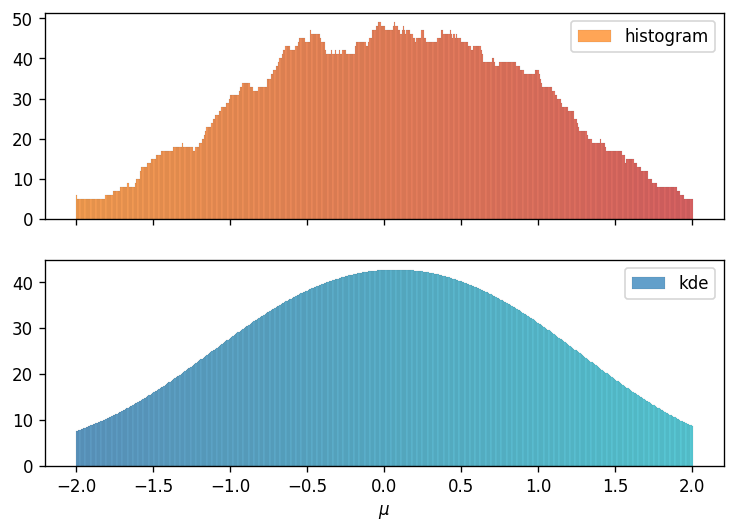

In [136]:
middle = len(bins)//2 - 1
mu_width = mu_grid[1]-mu_grid[0]

fig, axs = plt.subplots(2,1, sharex=True)

axs[0].bar(
    mu_grid, 
    hists[:,middle],
#     fill=False,
    color = fade('C1', 'C3', num_points=grid_points), 
    width = mu_width,
    alpha = .7,
    label = 'histogram',
    edgecolor= 'black',
    linewidth = 0.05
)
axs[0].legend()
axs[1].bar(
    mu_grid, 
    kde_hists[:,middle], 
    color = fade('C0', 'C9', num_points=grid_points), 
    width = mu_width,
    alpha = .7,
    label = 'kde',
    edgecolor= 'black',
    linewidth = 0.05
)
axs[1].legend()
plt.xlabel('$\mu$');

This envelope is much smoother than that of the original histogram, which follows from the smoothness of the (cumulative) density function defined by the kde, and allows us to get gradients!

Now that we have a histogram we can differentiate, we need to study its properties (and the gradients themselves!)

Two things to study:
- Quality of approximation to an actual histogram (and to the true distribution)
- Stability and validity of gradients

To make this more concrete of a comparison, let's introduce a third plot to the above panel that shows the area under the true distribution:

In [137]:
def true_hist(bins, mu):
    
    edge_hi = bins[1:]  # ending bin edges ||<-
    edge_lo = bins[:-1]  # starting bin edges ->||

    # get cumulative counts (area under curve) for each set of bin edges
    cdf_up = jsc.stats.norm.cdf(edge_hi.reshape(-1, 1), loc=mu)
    cdf_dn = jsc.stats.norm.cdf(edge_lo.reshape(-1, 1), loc=mu,)

    counts = (cdf_up - cdf_dn).T

    return counts

truth = true_hist(bins,mu_grid)
# make hists as before (but normalize)
bins = jnp.linspace(lo-1,hi+1,6)
make_kde_hists = jax.vmap(partial(kde_hist, bins = bins, bandwidth = .5, density=True))
kde_hists = make_kde_hists(points)
make_hists = jax.vmap(partial(jnp.histogram, bins = bins, density = True))
hists, _ = make_hists(points)

Text(0.5, 0.98, 'bandwidth = 0.5, #samples = 100')

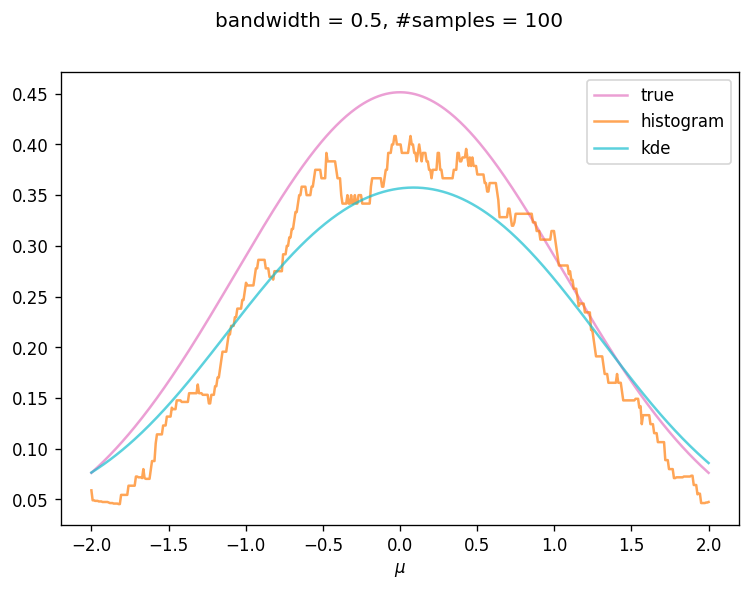

In [138]:
middle = len(bins)//2 - 1
mu_width = mu_grid[1]-mu_grid[0]

plt.plot(
    mu_grid, 
    truth[:,middle], 
    color = 'C6',
    alpha = .7,
    label = 'true',
)

plt.plot(
    mu_grid, 
    hists[:,middle],
#     fill=False,
    color = 'C1',
    alpha = .7,
    label = 'histogram',
)
plt.plot(
    mu_grid, 
    kde_hists[:,middle], 
    color = 'C9',
    alpha = .7,
    label = 'kde',
)
plt.legend()
plt.xlabel('$\mu$')
plt.suptitle("bandwidth = 0.5, #samples = 100")

The hyperparameter that will cause the quality of estimation to vary the most will be the *bandwidth* of the kde, which controls the width of the individual point-wise kernels. Moreover, since the kde is a data-driven estimator, the number of samples will also play a role.

Let's wrap the above plot construction into a function that we can call.

In [139]:
def make_mu_scan(bandwidth, num_samples, grid_points=500, lo=-2, hi=+2):
    
    mu_grid = jnp.linspace(lo, hi, grid_points)
    bins = jnp.linspace(lo-3,hi+3,6)
    
    truth = true_hist(bins,mu_grid)
    
    points = jnp.tile(
        normal(rng, shape = (num_samples,)), 
        reps = (grid_points,1)
        ) + mu_grid.reshape(-1,1)
    
    make_kde_hists = jax.vmap(
        partial(kde_hist, bins = bins, bandwidth = bandwidth, density=True)
    )
    kde_hists = make_kde_hists(points)
    make_hists = jax.vmap(partial(jnp.histogram, bins = bins, density = True))
    hists, _ = make_hists(points)
    study_bin = len(bins)//2 - 1
    return jnp.array([truth[:,study_bin], hists[:,study_bin], kde_hists[:,study_bin]])

In [140]:
# bws = jnp.linspace(0.05,0.8,8)
# lo_samp = jax.vmap(partial(make_mu_scan, num_samples = 100))
# hi_samp = jax.vmap(partial(make_mu_scan, num_samples = 100000))

# lo_hists = lo_samp(bws)
# hi_hists = hi_samp(bws)
# lo_hists.shape

In [141]:
# colors = fade('C3','C9',num_points=8)

In [142]:
# fig, axarr = plt.subplots(2,8, sharex=True, sharey=True)

# up, down = axarr
# for i,hists in enumerate(lo_hists):
#     [up[i].plot(mu_grid,hists[j],alpha=.6) for j in [0,1]]
#     up[i].plot(mu_grid,hists[2],alpha=.7,color=colors[i])
#     up[i].set_title(f'bw={bws[i]:.3f}', color=colors[i])
# up[0].set_ylabel('n=1e2', rotation=0, size='large')    
# for i,hists in enumerate(hi_hists):
#     [down[i].plot(mu_grid,hists[j],alpha=.6) for j in [0,1]]
#     down[i].plot(mu_grid,hists[2],alpha=.7,color=colors[i])
# down[0].set_ylabel('n=1e6', rotation=0, size='large')   

# fig.tight_layout();

Good, but we can do better with the function -- not everything needs to be repeated.

In [165]:
def make_points(num_samples, grid_points=300, lo=-2, hi=+2):
    mu_grid = jnp.linspace(lo, hi, grid_points)
    
    rngs = [PRNGKey(i) for i in range(9)]
    
    points = jnp.asarray(
        [
            jnp.tile(
                normal(rng, shape = (num_samples,)), 
                reps = (grid_points,1)
            ) + mu_grid.reshape(-1,1) for rng in rngs
        ]
    )
    
    return points, mu_grid


def make_kdes(points, bandwidth, bins):
    make_kde_hists = jax.vmap(
        partial(kde_hist, bins = bins, bandwidth = bandwidth)
    )
    return make_kde_hists(points)

def make_mu_scan(bandwidth, num_samples, grid_points=500, lo=-2, hi=+2):
    
    points, mu_grid = make_points(num_samples, grid_points, lo, hi)    
   
    bins = jnp.linspace(lo-3,hi+3,6)
    
    truth = true_hist(bins,mu_grid)*num_samples
    
    get_kde_hists = jax.vmap(partial(make_kdes, bins=bins, bandwidth=bandwidth))
    
    kde_hists = get_kde_hists(points)
    make_hists = jax.vmap(jax.vmap(partial(jnp.histogram, bins = bins)))
    hists, _ = make_hists(points)
    study_bin = len(bins)//2 - 1
    print(kde_hists.shape)
    print(hists.shape)
    print(truth.shape)


    h = jnp.array([truth[:,study_bin],
                   hists[:,:,study_bin].mean(axis=0),
                   kde_hists[:,:,study_bin].mean(axis=0)])
    stds = jnp.array([hists[:,:,study_bin].std(axis=0),
                      kde_hists[:,:,study_bin].std(axis=0)])
    return h, stds

In [166]:
bws = jnp.array([0.05,0.5,0.8])
lo_samp = jax.vmap(partial(make_mu_scan, num_samples = 20))
mid_samp = jax.vmap(partial(make_mu_scan, num_samples = 100))
hi_samp = jax.vmap(partial(make_mu_scan, num_samples = 5000))

lo_hists, lo_stds = lo_samp(bws)
mid_hists, mid_stds = mid_samp(bws)
hi_hists, hi_stds = hi_samp(bws)

(9, 500, 5)
(9, 500, 5)
(500, 5)
(9, 500, 5)
(9, 500, 5)
(500, 5)
(9, 500, 5)
(9, 500, 5)
(500, 5)


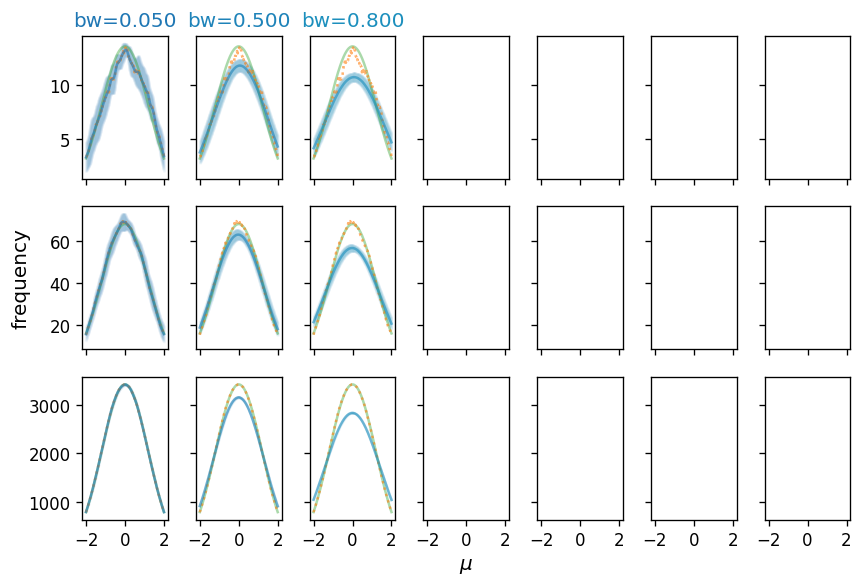

In [167]:
colors = fade('C0','C9',num_points=7)

fig, axarr = plt.subplots(3,7, sharex=True, sharey='row')

up, mid, down = axarr
for i,res in enumerate(zip(lo_hists, lo_stds)):
    hists, stds = res
    up[i].plot(mu_grid,hists[0],alpha=.4, color='C2',label="actual")
    up[i].plot(mu_grid,hists[1],alpha=.6, linestyle=':', color='C1',label="histogram")
    up[i].errorbar(mu_grid,hists[2],yerr=stds[1],alpha=.03,color=colors[i])
    up[i].plot(mu_grid,hists[2],alpha=.6,color=colors[i],label="kde histogram")
    up[i].set_title(f'bw={bws[i]:.3f}', color=colors[i])
#up[0].set_ylabel('n=1e2', rotation=0, size='large')  

for i,res in enumerate(zip(mid_hists, mid_stds)):
    hists, stds = res
    mid[i].plot(mu_grid,hists[0],alpha=.4, color='C2',label="true bin height")
    mid[i].plot(mu_grid,hists[1],alpha=.6, linestyle=':', color='C1',label="histogram")
    mid[i].errorbar(mu_grid,hists[2],yerr=stds[1],alpha=.03,color=colors[i])
    mid[i].plot(mu_grid,hists[2],alpha=.6,color=colors[i],label="kde histogram")

for i,res in enumerate(zip(hi_hists, hi_stds)):
    hists, stds = res
    down[i].plot(mu_grid,hists[0],alpha=.4, color='C2',label="actual")
    down[i].plot(mu_grid,hists[1],alpha=.6, linestyle=':', color='C1',label="histogram")
    down[i].errorbar(mu_grid,hists[2],yerr=stds[1],alpha=.03,color=colors[i])
    down[i].plot(mu_grid,hists[2],alpha=.6,color=colors[i],label="kde histogram")
#down[0].set_ylabel('n=1e6', rotation=0, size='large')   
down[3].set_xlabel("$\mu$",size='large')
mid[0].set_ylabel("frequency",size='large',labelpad=11)
mid[-1].legend(bbox_to_anchor=(1.1, 1.05), frameon=False)
fig.tight_layout();
plt.savefig('samples_vs_bw.png', bbox_inches='tight')

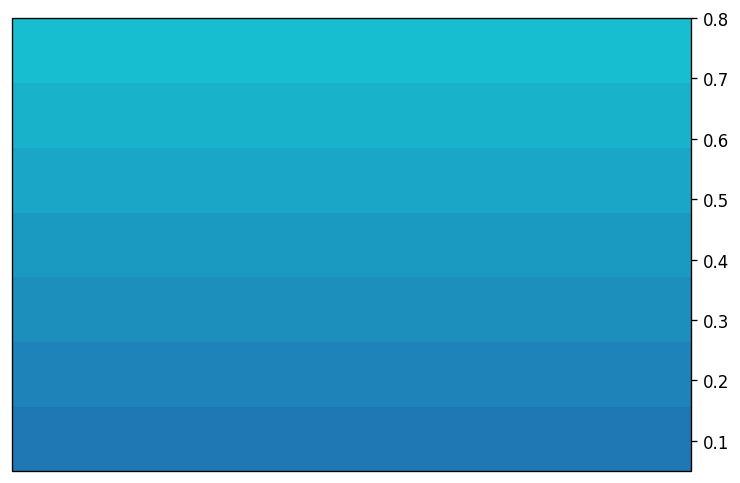

In [168]:

import matplotlib as mpl
colors = fade('C0','C9',num_points=7)
fig, ax = plt.subplots()

cmap = mpl.colors.ListedColormap(colors)
norm = mpl.colors.Normalize(vmin=bws[0], vmax=bws[-1])
mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm)


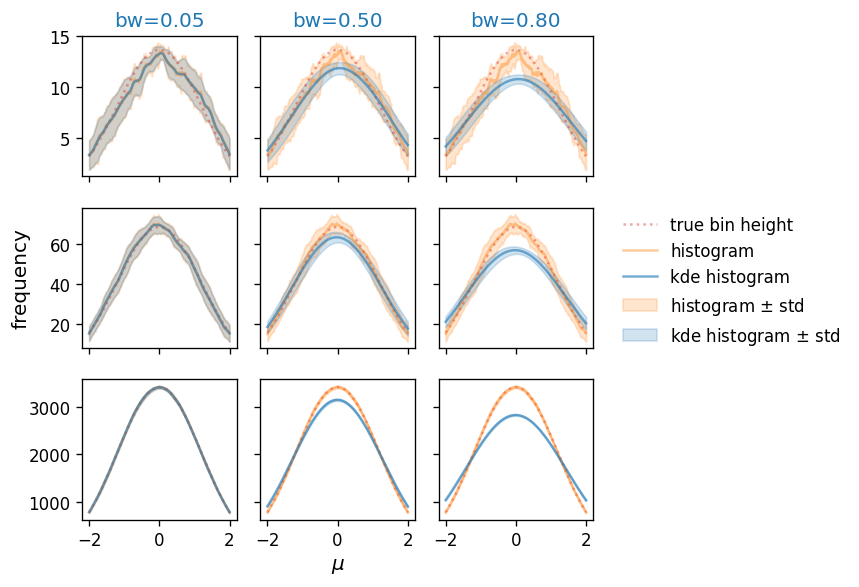

In [169]:
colors = fade('C0','C9',num_points=7)

fig, axarr = plt.subplots(3,len(bws), sharex=True, sharey='row')

up, mid, down = axarr
for i,res in enumerate(zip(lo_hists, lo_stds)):
    hists, stds = res
    up[i].plot(mu_grid,hists[0],alpha=.4, color='C3',label="actual", linestyle=':')
    up[i].fill_between(mu_grid, hists[1]+stds[0], hists[1]-stds[0], alpha=.2,color='C1',label='histogram variance')
    up[i].plot(mu_grid,hists[1],alpha=.4, color='C1',label="histogram")
    up[i].fill_between(mu_grid, hists[2]+stds[1], hists[2]-stds[1], alpha=.2,color='C0')
    up[i].plot(mu_grid,hists[2],alpha=.6,color='C0',label="kde histogram")
    up[i].set_title(f'bw={bws[i]:.2f}', color='C0')
#up[0].set_ylabel('n=1e2', rotation=0, size='large')  

for i,res in enumerate(zip(mid_hists, mid_stds)):
    hists, stds = res
    mid[i].plot(mu_grid,hists[0],alpha=.4, color='C3',label="true bin height", linestyle=':')
    mid[i].fill_between(mu_grid, hists[1]+stds[0], hists[1]-stds[0], alpha=.2,color='C1',label='histogram $\pm$ std')
    mid[i].plot(mu_grid,hists[1],alpha=.4,color='C1',label="histogram")
    mid[i].fill_between(mu_grid, hists[2]+stds[1], hists[2]-stds[1], alpha=.2,color='C0',label='kde histogram $\pm$ std')
    mid[i].plot(mu_grid,hists[2],alpha=.6,color='C0',label="kde histogram")

for i,res in enumerate(zip(hi_hists, hi_stds)):
    hists, stds = res
    down[i].plot(mu_grid,hists[0],alpha=.4, color='C3',label="actual", linestyle=':')
    down[i].fill_between(mu_grid, hists[1]+stds[0], hists[1]-stds[0], alpha=.2,color='C1')
    down[i].plot(mu_grid,hists[1],alpha=.4, color='C1',label="histogram")
    down[i].fill_between(mu_grid, hists[2]+stds[1], hists[2]-stds[1], alpha=.2,color='C0')
    down[i].plot(mu_grid,hists[2],alpha=.6,color='C0',label="kde histogram")
#down[0].set_ylabel('n=1e6', rotation=0, size='large')   
down[1].set_xlabel("$\mu$",size='large')
mid[0].set_ylabel("frequency",size='large',labelpad=11)
mid[-1].legend(bbox_to_anchor=(1.1, 1.05), frameon=False)
fig.tight_layout();
plt.savefig('samples_vs_bw_nofancy.png', bbox_inches='tight')

Cool! Now, let's think about gradients.

Since we know analytically that the height of a bin defined by $(a,b)$ for a given $\mu$ value is just

$$bin_{\mathsf{true}}(\mu) = \mathsf{normcdf}(b;\mu) - \mathsf{normcdf}(a;\mu) $$

The histogram's gradient will be ill-defined, but we can get an estimate of this through finite differences:

$$\mathsf{grad}_{\mathsf{hist}}(bin)(\mu_i) \approx \frac{bin(\mu_{i+1})-bin(\mu_i)}{\mu_{i+1}-\mu_{i}}$$

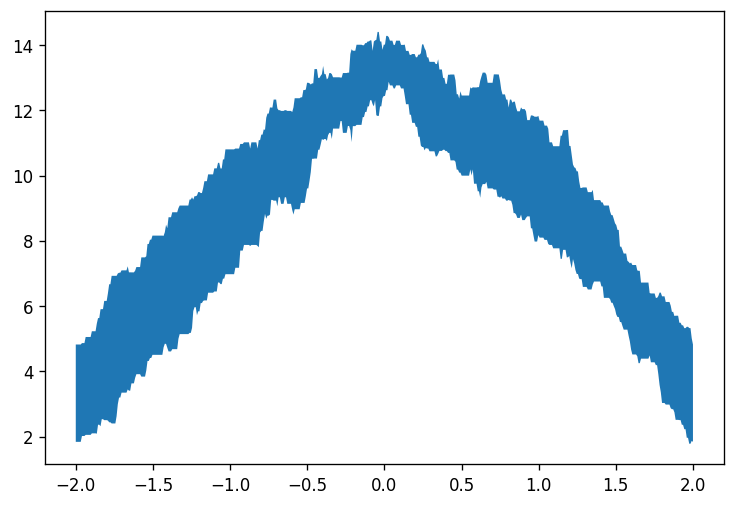

In [170]:
s = lo_stds[0][0]
h = lo_hists[0][1]
plt.fill_between(mu_grid, h+s, h-s)

In [171]:
lo_stds[0][0]

DeviceArray([1.4907119 , 1.4907119 , 1.4907119 , 1.4907119 , 1.4907119 ,
             1.4229165 , 1.4229165 , 1.4229165 , 1.4989707 , 1.4989707 ,
             1.4989707 , 1.4989707 , 1.4989707 , 1.5634719 , 1.5634719 ,
             1.5634719 , 1.5634719 , 1.6850835 , 1.6329932 , 1.6329932 ,
             1.7916127 , 1.6850835 , 1.6850835 , 1.8257419 , 1.8257419 ,
             1.8257419 , 1.9499922 , 2.1140332 , 2.1140332 , 2.2607768 ,
             2.2607768 , 2.2607768 , 2.2607768 , 2.1487865 , 2.        ,
             1.9116278 , 1.9116278 , 1.8724778 , 1.8724778 , 1.8724778 ,
             1.8724778 , 1.8724778 , 1.8856181 , 1.8121674 , 1.8121674 ,
             1.6996732 , 1.6996732 , 1.6996732 , 1.6405358 , 1.6405358 ,
             1.6405358 , 1.6405358 , 1.6405358 , 1.8257418 , 1.8257418 ,
             1.8257418 , 1.8257418 , 1.7497796 , 1.7916129 , 1.7916129 ,
             1.8121674 , 1.8121674 , 1.8257419 , 1.8257419 , 1.8257419 ,
             1.8257419 , 1.8257419 , 1.8257419 , 1.